In [1]:
import numpy as np

In [2]:
class NEURON:
    """
    This class implements several conveniences for 
    visualizing firing activity of single neurons
    
    Parameters
    ----------
    spiketimes: float, array of spike times
    
    
    Methods
    -------
    plot_raster
    plot_psth
    get_trialtype
    get_spikecounts
    plot_tuning_curve
    fit_tuning_curve
    """
    
    def __init__(self, spiketimes, name='neuron'):
        """
        Initialize the object
        """
        self.name = name
        self.spiketimes = spiketimes
        n_seconds = (self.spiketimes[-1]-self.spiketimes[0])
        n_spikes = np.size(spiketimes)
        self.firingrate = (n_spikes/n_seconds)

    #-----------------------------------------------------------------------
    def get_raster(self, events, features=[], selectors=[], \
                   window=[-100, 500], binsize=10, plot=True, sort=True):
        """
        Compute the raster and plot it
        
        Parameters
        ----------
        events: float, n x 1 array of event times 
                (e.g. stimulus/ trial/ fixation onset, etc.)

        """
    
        # Get a set of binary indicators for trials of interest
        if len(selectors) > 0:
            trials = self.get_trialtype(features, selectors)
        else:
            trials = np.transpose(np.atleast_2d(np.ones(np.size(events)) == 1))

        # Initialize rasters
        Rasters = dict()

        # Assign time bins
        firstspike = self.spiketimes[0]
        lastspike = self.spiketimes[-1]
        bins = np.arange(np.floor(firstspike),np.ceil(lastspike), 1e-3*binsize)

        # Loop over each raster
        for r in np.arange(trials.shape[1]):

            # Select events relevant to this raster
            selected_events = events[trials[:,r]]

            # Eliminate events before the first spike after last spike
            selected_events = selected_events[selected_events > firstspike]
            selected_events = selected_events[selected_events < lastspike]

            # bin the spikes into time bins
            spike_counts = np.histogram(self.spiketimes, bins)[0]
             
            # bin the events into time bins 
            event_counts = np.histogram(selected_events, bins)[0]
            event_bins =  np.where(event_counts > 0)[0]

            raster = np.array([(spike_counts[(i+window[0]/binsize): \
                                             (i+window[1]/binsize)]) \
                               for i in event_bins])
            Rasters[r] = raster
    
        # Show the raster     
        if plot == True:
            for i,r in enumerate(Rasters):
                raster = Rasters[r]

                
                if sort == True:
                    # Sorting by total spike count in the duration
                    raster_sorted = raster[np.sum(raster, axis=1).argsort()]
                else:
                    raster_sorted = raster
                plt.imshow(raster_sorted, aspect='auto', interpolation='none')
                plt.ylabel('trials')
                plt.xlabel('time [ms]')

                ax = plt.gca()
                xtics = np.arange(window[0], window[1], binsize*10)
                xtics = [str(i) for i in xtics]

                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                ax.spines['bottom'].set_visible(False)
                ax.spines['left'].set_visible(False)
                plt.xticks(np.arange(0,(window[1]-window[0])/binsize,10), xtics)
                plt.title('%s: Average firing rate %.1f Spks/s' % (self.name, self.firingrate))
                plt.axvline((-window[0])/binsize, color='r', linestyle='solid')
                plt.show()

    
        # Return all the rasters
        return Rasters
             
    #-----------------------------------------------------------------------
    def get_psth(self, events, features=[], selectors=[], \
                 window=[-100, 500], binsize=10, plot=True, \
                 colors=['#F5A21E','#134B64','#EF3E34','#02A68E','#FF07CD']):
        """
        Compute the psth and plot it
        
        Parameters
        ----------
        events: float, n x 1 array of event times 
                (e.g. stimulus/ trial/ fixation onset, etc.)
        """
        
        # Get all the rasters first
        Rasters = self.get_raster(events, features, selectors, window, binsize, plot=False)
        
        # Open the figure
        if plot == True:
            fig = plt.figure()
        
        # Initialize PSTH
        PSTH = dict()
    
        # Compute the PSTH
        for i, r in enumerate(Rasters):
            color = colors[i]
            PSTH[i] = dict()
            raster = Rasters[r]
             
            mean_psth = np.mean(raster,axis=0)/(1e-3*binsize)
            std_psth = np.sqrt(np.var(raster,axis=0))/(1e-3*binsize)
            sem_psth = std_psth/np.shape(mean_psth)[0]

            PSTH[i]['mean'] = mean_psth
            PSTH[i]['sem'] = sem_psth
            
            # Visualize the PSTH
            if plot == True:

                xx = np.linspace(window[0], window[1], num=np.diff(window)/binsize)
                
                fig.suptitle('PSTH', fontsize=14, fontweight='bold')
                ax = fig.add_subplot(111)
                fig.subplots_adjust(top=0.85)

                ax.plot([0,0],[0,np.max(mean_psth)], color='k')

                ax.plot(xx, mean_psth, color=color,lw=2)
                ax.plot(xx, mean_psth+sem_psth, color=color, ls =':')
                ax.plot(xx, mean_psth-sem_psth, color=color, ls =':')
                ax.legend(['event'])
                ax.set_title('%s: Average firing rate %.1f Spks/s' % (self.name, self.firingrate))
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                ax.set_xlabel('time [ms]')
                ax.set_ylabel('spikes per second [spks/s]') 
            
        return PSTH
        
    #-----------------------------------------------------------------------
    def get_trialtype(self, features, selectors):
        """
        For an arbitrary query on features 
        get a subset of trials
        
        Parameters
        ----------
        features: float, n x p array of features, 
                  n trials, p features 
                  (e.g. stimulus/ behavioral features)
        selectors: list of intervals on arbitrary features
        
        Outputs
        -------
        trials: bool, n x 1 array of indicators
        """
        trials = []
        for r in selectors:
            selector = selectors[r]
            trials.append([np.all([np.all((features[r] >= selector[r][0], \
                                 features[r] <= selector[r][-1]), axis=0) \
                                 for r in selector], axis=0)])
        return np.transpose(np.atleast_2d(np.squeeze(trials)))
        
    #-----------------------------------------------------------------------
    def get_spikecounts(self, events, window = 1e-3*np.array([50.0, 100.0])):
        """
        Parameters
        ----------
        events: float, n x 1 array of event times
                (e.g. stimulus onset, trial onset, fixation onset, etc.)
        win: denoting the intervals
        
        Outputs
        -------
        spikecounts: float, n x 1 array of spike counts
        """
        y = np.zeros(events.shape)
        for e in len(events):
            spikecounts[e] = np.sum(np.all((spiketimes >= events[e] + window[0], \
                                            spiketimes <= events[e] + window[1]), \
                                            axis=0))
        return spikecounts
    
    #-----------------------------------------------------------------------
    def plot_tuning_curve(self, feature, spikecounts):
        plt.plot(feature, spikecounts, '.')
        

In [3]:
import h5py
import deepdish as dd
import os
from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline
def set_style():
    plt.style.use(['seaborn-white', 'seaborn-pastel'])
    plt.rc("font", family="Arial")
    
set_style()

In [4]:
#Letz load some data
Monkey  = 'M1' #choose monkey
h5path = '/Volumes/JUICE/lab projects/V4_CNN/V4pydata/H5data/' + Monkey
fname = os.listdir(h5path)
thisfile = fname[0] #choose a session
dat = dd.io.load(h5path+'/'+ thisfile) #load

print 'loaded session: %s of monkey %s' % (thisfile[:-3], Monkey)
print "we have a dictionary with 2 fields: %s" % str(dat.keys())
print "and a total of %.0f neurons" % np.size(dat['spikes'].keys())

#letz get spikes and the list of neuron ids
spikes = dat['spikes']
neuron_list = dat['spikes'].keys()

loaded session: bucky090910 of monkey M1
we have a dictionary with 2 fields: ['eyes', 'spikes']
and a total of 142 neurons


In [5]:
#letz look at neuron number 50, for instance ;)
neuronid = neuron_list[50]
spikes = dat['spikes'][neuronid]

#letz do it!
neuron = NEURON(spikes)
neuron

<__main__.NEURON instance at 0x1103f1b48>

In [6]:
# what's its name?
neuron.name

'neuron'

In [7]:
#oh, let's do it like this instead
neuron = NEURON(spikes, name = neuronid)
neuron.name

'3301'

In [8]:
#Ah
#what's itz firing rate?
neuron.firingrate

30.196534012735512

In [9]:
#nice, coincidently ;) we chose a neuron that spikes a lot

#letz get a PSTH for this neuron!, 
#first we need to an event to which we will aligh the trials to
#letz check what we have on our data
[i for i in dat['eyes'][0]]

['imname',
 'fix_offset',
 'fixation',
 'out_sac_dur',
 'impath',
 'trial',
 'in_sac_dur',
 'fix_onset',
 'col',
 'row']

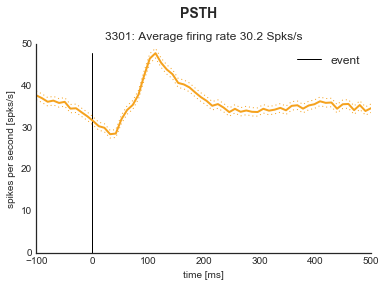

In [10]:
#hmmmm letz use fixation onset
fix_onset_times = np.array([dat['eyes'][fix]['fix_onset'] for fix in dat['eyes']])
neuron.get_psth(fix_onset_times);

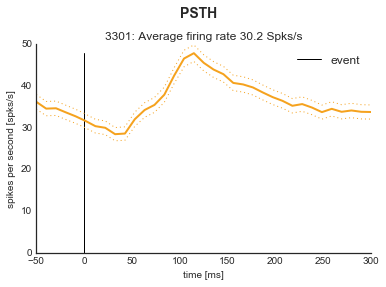

In [11]:
# in a narrower time window
neuron.get_psth(fix_onset_times, window = [-50, 300]);

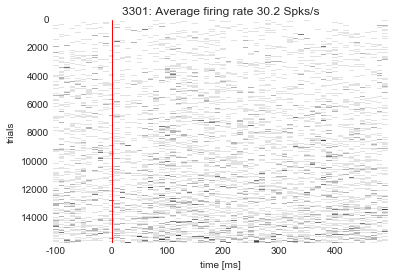

In [12]:
#how about rasters
neuron.get_raster(fix_onset_times);

In [13]:
# how about restricting the trials to certain conditions
# Letz get some features
fix_onset_times = np.array([dat['eyes'][fix]['fix_onset'] for fix in dat['eyes']])
fix_offset_times = np.array([dat['eyes'][fix]['fix_offset'] for fix in dat['eyes']])
fix_col = np.array([dat['eyes'][fix]['col'] for fix in dat['eyes']])
fix_row = np.array([dat['eyes'][fix]['col'] for fix in dat['eyes']])

features = {}
features['fix_duration'] = (fix_offset_times-fix_onset_times)*1000
features['in_screen_row'] = fix_row
features['in_screen_col'] = fix_col
features['a fake feature'] = [] 
features['yet another fake feature'] = [] 

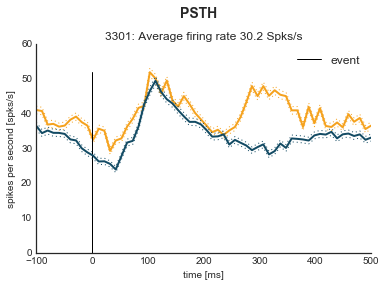

In [14]:
# Now that we have features Letz impose some restriction on which subset of trials we want to look at  
#######################################

# how about trials that are inside the screen
selectors = {}
selectors[0]= {}
selectors[0]['in_screen_row'] = [1, 1024]
selectors[0]['in_screen_col'] = [1, 768]
#and that have a fixation duration between [20,150]ms
selectors[0]['fix_duration'] = [80, 180]

#and letz compare that to those inside the screen with fixation duration between [200,1000]ms
selectors[1]= {}
selectors[1]['in_screen_row'] = [1, 1024]
selectors[1]['in_screen_col'] = [1, 768]
selectors[1]['fix_duration'] = [200, 1000]

neuron.get_psth(fix_onset_times, features, selectors);

bigger time window


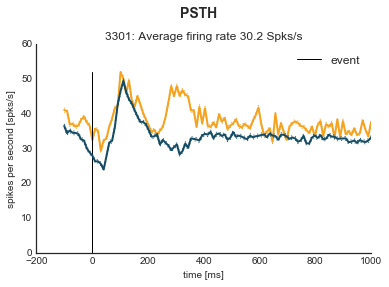

In [15]:
print 'bigger time window'
neuron.get_psth(fix_onset_times, features, selectors, window = [-100,1000]);

default binsizes are 10ms, letz try with 50ms


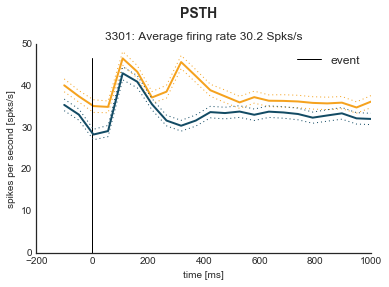

In [16]:
print 'default binsizes are 10ms, letz try with 50ms'
neuron.get_psth(fix_onset_times, features, selectors, window = [-100,1000], binsize=50);

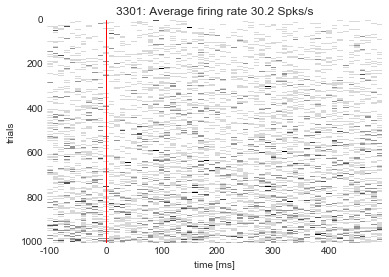

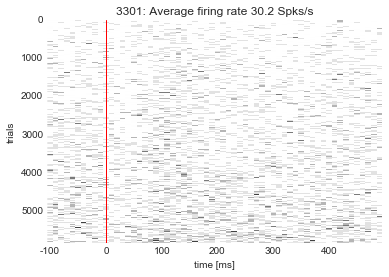

In [17]:
#and now some rasters
neuron.get_raster(fix_onset_times, features, selectors);

In [18]:
#we can also get the rasters data
Rasters = neuron.get_raster(fix_onset_times, features, selectors, plot=False)
Rasters

{0: array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 2, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1],
        ..., 
        [0, 1, 0, ..., 0, 0, 2],
        [3, 1, 0, ..., 0, 1, 1],
        [0, 0, 0, ..., 0, 0, 1]]), 1: array([[0, 0, 0, ..., 1, 0, 0],
        [1, 1, 1, ..., 0, 0, 3],
        [0, 0, 0, ..., 2, 0, 1],
        ..., 
        [0, 0, 1, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 1, 0, 0]])}

In [19]:
#and the psths
PSTHs = neuron.get_psth(fix_onset_times, features, selectors, plot=False)
PSTHs

{0: {'mean': array([ 41.03585657,  40.73705179,  36.85258964,  37.05179283,
          36.25498008,  36.55378486,  38.24701195,  39.14342629,
          37.5498008 ,  36.55378486,  32.47011952,  35.65737052,
          35.05976096,  29.28286853,  32.27091633,  32.8685259 ,
          36.25498008,  38.54581673,  41.63346614,  42.2310757 ,
          51.89243028,  50.09960159,  45.81673307,  49.50199203,
          43.7250996 ,  42.03187251,  45.01992032,  42.72908367,
          40.13944223,  38.34661355,  36.55378486,  34.66135458,
          35.35856574,  33.86454183,  35.15936255,  36.15537849,
          39.0438247 ,  43.22709163,  47.90836653,  45.01992032,
          47.90836653,  45.11952191,  46.71314741,  45.41832669,
          45.01992032,  40.93625498,  40.93625498,  36.15537849,
          41.93227092,  37.25099602,  41.53386454,  36.45418327,
          36.15537849,  37.4501992 ,  36.05577689,  39.84063745,
          37.64940239,  38.74501992,  35.55776892,  36.55378486]),
  'sem': arr